In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import tree
import graphviz 

import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff
import plotly

plotly.offline.init_notebook_mode(connected=True)

In [4]:
clients = pd.read_csv('clients.csv', sep=';')
trans = pd.read_csv('FixPrice_transactions.csv', sep=';')
categories = pd.read_csv('client_categories.csv', sep=';')

In [5]:
categories.head()

,category,description
0,10,VIP/ Management recommendations
1,11,VIP/ Management recommendations (family)
2,17,Private Banking customers walk-in
3,18,Private banking customers payroll
4,20,High income individuals


In [6]:
clients.head()

,cnum_,categorycode,gender,age,married_,residenttype
0,0CCCDO,81,M,32,not_married,R
1,0CCCFO,70,F,42,not_married,R
2,0CCCGC,50,F,33,married,R
3,0CCCGG,70,M,58,not_married,R
4,0CCCGO,60,M,38,married,R


In [7]:
trans.head()

,purchdate,amount,mcc,mrchcity,mrchname,cnum
0,2019-09-23,20582.0,5311,TEMRYUK,94NWJ4I1 B6F5,ELHHAC
1,2019-10-23,14460.0,5311,KRASNODAR,94NWJ4I1 QPGS,ELHHAC
2,2019-10-08,12889.7,5311,TULA,94NWJ4I1 B6MF,EEI105
3,2019-10-11,11981.0,5311,KOLCZOVO,94NWJ4I1 5GPM,EL97DD
4,2019-11-30,11781.0,5311,YASNOGORSK,94NWJ4I1 QBPQ,ELEL21


In [8]:
revenue = trans.groupby('cnum')[['amount']].sum().reset_index()
orders = trans.groupby('cnum')[['amount']].count().reset_index()
orders = orders.rename({'amount' : 'orders'}, axis=1)

client_info = pd.merge(left=revenue, right=orders, on='cnum')
client_info['average_check'] = client_info['amount']/client_info['orders']

client_info = pd.merge(left=client_info, right=clients,
                       left_on='cnum', right_on='cnum_')
client_info = client_info.drop('cnum_', axis=1)
client_info['client_cat'] = pd.qcut(client_info['amount'], 4, labels = False)
client_info.head()

,cnum,amount,orders,average_check,categorycode,gender,age,married_,residenttype,client_cat
0,0CCCGC,1120.3,1,1120.3,50,F,33,married,R,3
1,0CCDNG,887.5,1,887.5,50,F,39,married,R,2
2,0CCFDD,2604.6,2,1302.3,50,M,54,married,R,3
3,0CCFFD,497.0,1,497.0,70,M,34,married,R,2
4,0CCFXY,55.0,1,55.0,50,M,59,married,R,0


In [9]:
client_info['gender_cat'] = pd.factorize(client_info['gender'])[0]
client_info['married_cat'] = pd.factorize(client_info['married_'])[0]
client_info['code_cat'] = pd.factorize(client_info['categorycode'])[0]
client_info.head()

,cnum,amount,orders,average_check,categorycode,gender,age,married_,residenttype,client_cat,gender_cat,married_cat,code_cat
0,0CCCGC,1120.3,1,1120.3,50,F,33,married,R,3,0,0,0
1,0CCDNG,887.5,1,887.5,50,F,39,married,R,2,0,0,0
2,0CCFDD,2604.6,2,1302.3,50,M,54,married,R,3,1,0,0
3,0CCFFD,497.0,1,497.0,70,M,34,married,R,2,1,0,1
4,0CCFXY,55.0,1,55.0,50,M,59,married,R,0,1,0,0


In [10]:
clf = tree.DecisionTreeRegressor(max_depth=4,min_samples_leaf=500, criterion='friedman_mse')
X = client_info[['code_cat', 'age', 'gender_cat', 'married_cat']]
Y = client_info[['amount']]

clf = clf.fit(X, Y)

In [33]:
feature_names = {
    0 : 'code',
    1 : 'age',
    2 : 'gender',
    3 : 'married'
}

value_data = pd.DataFrame(columns=['path', 'value'])
value_data

,path,value


In [32]:
def search_tree(tree, node, features):
    global value_data
            
    if tree.children_left[node] == -1 and tree.children_right[node] == -1:
        value_data = value_data.append({'path' : features, 
                                        'value' : tree.value[node][0][0]}, ignore_index=True)
        return
    
    feature_name = feature_names[tree.feature[node]]
    threshold = tree.threshold[node]
    
    
    
    if tree.children_left[node] != -1:
        left_features = features + feature_name + ' <= ' + str(threshold) + ';'
        search_tree(tree, tree.children_left[node], left_features)
        
    if tree.children_right[node] != -1:
        right_features = features + feature_name + ' > ' + str(threshold) + ';'
        search_tree(tree, tree.children_right[node], right_features)
    


In [34]:
search_tree(clf.tree_, 0, '')

In [35]:
value_data.sort_values(by='value', ascending=False)

,path,value
10,gender > 0.5;married <= 0.5;code > 1.5;age <= ...,1264.793175
11,gender > 0.5;married <= 0.5;code > 1.5;age > 4...,1090.465769
4,gender <= 0.5;age > 23.5;code <= 0.5;age <= 47.5;,1015.183583
7,gender <= 0.5;age > 23.5;code > 0.5;code > 1.5;,1007.801831
5,gender <= 0.5;age > 23.5;code <= 0.5;age > 47.5;,897.655111
15,gender > 0.5;married > 0.5;age > 23.5;code > 1.5;,868.779071
8,gender > 0.5;married <= 0.5;code <= 1.5;code <...,842.239278
6,gender <= 0.5;age > 23.5;code > 0.5;code <= 1.5;,805.339904
9,gender > 0.5;married <= 0.5;code <= 1.5;code >...,768.490127
2,gender <= 0.5;age <= 23.5;age > 20.5;code <= 0.5;,757.464756


In [40]:
value_data.sort_values(by='value', ascending=False).iloc[0]['path']

'gender > 0.5;married <= 0.5;code > 1.5;age <= 44.5;'

In [37]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=['code_cat', 'age', 'gender_cat', 'married_cat'],  
                                filled=True, rounded=True,  
                                special_characters=True)

graph = graphviz.Source(dot_data) 

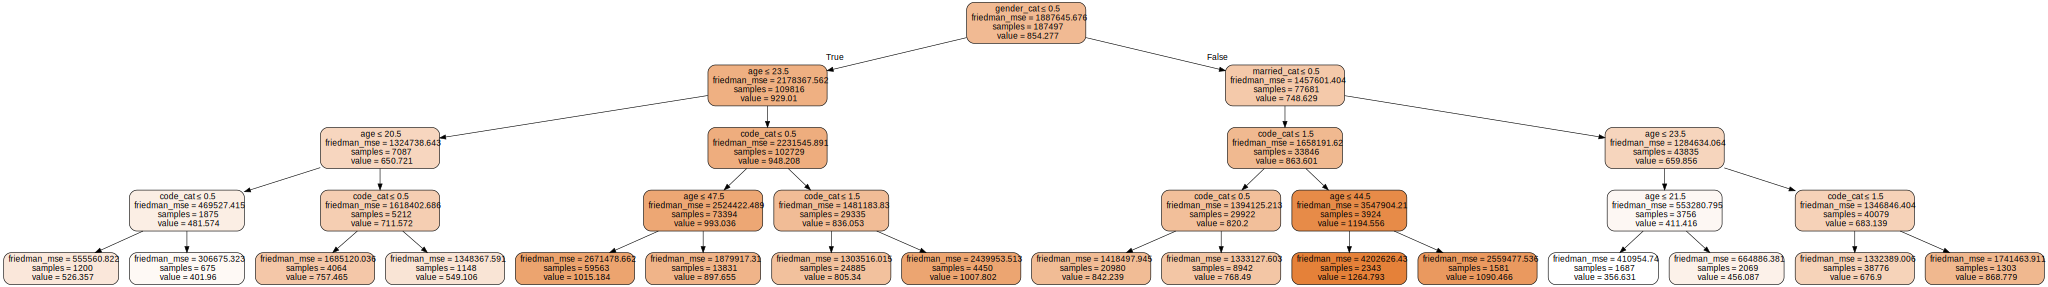

In [38]:
graph

# value = средняя выручка от человека в сегменте
# married = 0
# female = 0